In [2]:
#Read in files using pandas
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
data = pd.read_csv('data/new_data/new_incidents2009_wHeader.csv')
data = data.dropna(axis=0)
data = data.astype('str')
data

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Call_Category,Master_Incident_Number,Jurisdiction,Problem,Lat_Lon,Street_Block,City,Postal_Code,PhonePickUp,Time_First_Staged_Arrived,Total_Response_Time,Cross_Street
0,Emergency Medical Response,FS09000001,San Diego,Stabbing/Gunshot (L1),32.71593_-117.13288,28TH ST/29TH ST,SAN DIEGO,92102,1/1/09 0:05:49,1/1/09 0:08:08,0:02:19,2800 BROADWAY
1,Emergency Medical Response,FS09000003,San Diego,Assault/Rape (L1),32.75589_-117.088,TROJAN AV/EL CAJON BL,SAN DIEGO,92115,1/1/09 0:07:21,1/1/09 0:17:06,0:09:45,4300 WINONA AV
2,Emergency Medical Response,FS09000002,San Diego,Unc/Fainting (Non Trauma)(L1),32.71583_-117.15195,14TH ST/15TH ST,SAN DIEGO,92101,1/1/09 0:07:26,1/1/09 0:11:56,0:04:30,1400 BROADWAY
3,Emergency Medical Response,FS09000004,San Diego,Falls / Back Inj (Trauma) (L1),32.79954_-117.08041,IRWIN AV/GLENROY ST,SAN DIEGO,92120,1/1/09 0:09:55,1/1/09 0:15:59,0:06:04,5200 LEWISON AV
4,Emergency Medical Response,FS09000005,San Diego,Unc/Fainting (Non Trauma)(L1),32.71473_-117.16088,04TH AV/05TH AV,SAN DIEGO,92101,1/1/09 0:10:33,1/1/09 0:14:07,0:03:34,400 E ST
5,Emergency Medical Response,FS09000006,San Diego,Breathing Problems (L1),32.70603_-117.09428,Dead End/47TH ST,SAN DIEGO,92102,1/1/09 0:11:10,1/1/09 0:15:33,0:04:23,4600 NOGAL ST
6,Urgent Medical Response,FS09000007,San Diego,Heart Problems (L3),32.68896_-117.02559,GOODE ST/WESTBROOK AV,SAN DIEGO,92139,1/1/09 0:18:45,1/1/09 0:41:28,0:22:43,1600 MANZANA WY
7,Urgent Medical Response,FS09000008,San Diego,"Traumatic Injuries, Spec (L3)",32.71076_-117.16824,Dead End/W HARBOR DR,SAN DIEGO,92101,1/1/09 0:19:08,1/1/09 0:31:02,0:11:54,1 MARKET PL
8,HAZARD,FS09000009,San Diego,Ringing Alarm Highrise,32.71852_-117.16171,01ST AV/Dead End,SAN DIEGO,92101,1/1/09 0:19:53,1/1/09 0:24:41,0:04:48,1 HORTON PZ
10,Emergency Medical Response,FS09000011,San Diego,"Traumatic Injuries, Spec (L1)",32.79641_-117.25654,OCEAN BL/Dead End,SAN DIEGO,92109,1/1/09 0:23:27,1/1/09 0:30:08,0:06:41,700 GARNET AV


In [3]:
#Data file processing
clean_data = data
clean_data['PhonePickUp'] = data['PhonePickUp'].apply(lambda x: dt.datetime.strptime(x,"%m/%d/%y %H:%M:%S"))
clean_data['Hour'] = data["PhonePickUp"].apply(lambda x: x.hour)
clean_data['Day'] = data["PhonePickUp"].apply(lambda x: x.day)
clean_data['Month'] = data["PhonePickUp"].apply(lambda x: x.month)

In [4]:
clean_data['Lat'] = data["Lat_Lon"].apply(lambda x: float(x.split("_")[0]))
clean_data['Lon'] = data["Lat_Lon"].apply(lambda x: float(x.split("_")[1]))

In [6]:
import bisect
gridHorizontalGranularity = 220
corners = [(33.112853, -117.358872), (32.644608, -116.883714)]
ratio = (corners[0][0]-corners[1][0])/(corners[1][1]-corners[0][1])
gridVerticleGranularity = int(ratio * gridHorizontalGranularity)
gridRows = [0 for _ in range(gridVerticleGranularity)]
gridCols = [0 for _ in range(gridHorizontalGranularity)]
def getGrid():
    vertSteps = gridVerticleGranularity
    horizontalSteps = gridHorizontalGranularity
    deltaLat = corners[0][0]-corners[1][0]
    deltaLong = corners[0][1]-corners[1][1]
    for r in xrange(0,gridVerticleGranularity):
        gridRows[r] = corners[0][0] - (float(r)/gridVerticleGranularity)*(deltaLat)
    for c in xrange(0,gridHorizontalGranularity):
        gridCols[c] = corners[0][1] - (float(c)/gridHorizontalGranularity)*(deltaLong)

grid = getGrid()
def getRow(lat):
    curRow = 0
    while curRow < gridVerticleGranularity-1:
        if gridRows[curRow] < lat:
            break
        curRow += 1
    return curRow

def getCol(longd):
    curCol = 0
    while curCol < gridHorizontalGranularity-1:
        if gridCols[curCol] > longd:
            break
        curCol += 1
    return curCol

In [7]:
clean_data['Row'] = clean_data['Lat'].apply(lambda x: getRow(x))
clean_data['Col'] = clean_data['Lon'].apply(lambda x: getCol(x))
clean_data = clean_data.dropna(axis=0)

In [9]:
def timeDiff(t,tp):
    return t-tp
def manDist(x,y,xp,yp):
    return abs(x-xp) + abs(y-yp)
def spaceTimeKernel(timediff, manDist):
    if timediff.days > 21 or manDist > 3:
        return 0
    tFactor = 1+(abs(timediff.days)/7.0)
    dFactor = 1+manDist
    kern = 1.0/(tFactor*dFactor)
    return kern

In [29]:
from random import randrange

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + dt.timedelta(seconds=random_second)
d1 = dt.datetime.strptime('1/1/2009 1:00 AM', '%m/%d/%Y %I:%M %p')
d2 = dt.datetime.strptime('1/1/2010 1:00 AM', '%m/%d/%Y %I:%M %p')

pred_day = random_date(d1, d2)
end_day = pred_day + dt.timedelta(days=1)
print pred_day, end_day
train_data = clean_data[(clean_data['PhonePickUp'] < pred_day)]
train_data = train_data[['Row','Col','PhonePickUp']]
train_data = train_data.values
test_data = clean_data[((clean_data['PhonePickUp'] > pred_day) & (clean_data['PhonePickUp'] <= end_day))]
test_data = test_data[['Row','Col','PhonePickUp']]
test_data = test_data.values
print "Number of train entries =", len(train_data)
print "Number of test entries =", len(test_data)

2009-07-27 04:29:12 2009-07-28 04:29:12
Number of train entries = 50908
Number of test entries = 240


In [30]:
predicitionMap = [[0 for i in xrange(0,gridHorizontalGranularity)] for j in xrange(0,gridVerticleGranularity)]
for d in train_data:
    row = d[0]
    col = d[1]
    time = d[2]
    start_col = max(col-3, 0)
    end_col = min(col+3,gridHorizontalGranularity)
    start_row = max(row-3, 0)
    end_row = min(row+3,gridVerticleGranularity)
    for i in range(start_row,end_row):
        for j in range(start_col,end_col):
            timeDelta = timeDiff(pred_day, time)
            spaceDelta = manDist(row,col,i,j)
            predicitionMap[i][j]+=spaceTimeKernel(timeDelta,spaceDelta)

In [31]:
maxPositions = []
for i in range(gridVerticleGranularity):
    for j in range(gridHorizontalGranularity):
        maxPositions.append((predicitionMap[i][j],i,j))
len(maxPositions)

47520

In [147]:
percent = .005
num_pred_locations = int(percent*gridVerticleGranularity*gridHorizontalGranularity)
maxPositions = sorted(maxPositions, key = lambda x: x[0], reverse=True)
predPositions = maxPositions[0:num_pred_locations]
print len(predPositions)

237


In [148]:
predicitedLocMap = [[0 for i in xrange(0,gridHorizontalGranularity)] for j in xrange(0,gridVerticleGranularity)]
for (val,row,col) in predPositions:
    predicitedLocMap[row][col] = 1

In [34]:
num_captured = 0
for d in test_data:
    row = d[0]
    col = d[1]
    if predicitedLocMap[row][col] == 1:
        num_captured+=1

In [35]:
num_captured

82

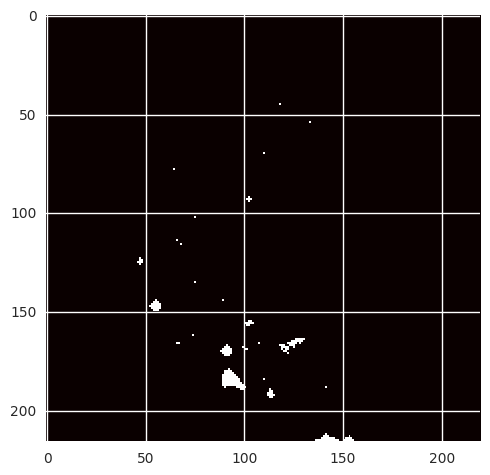

In [149]:
predicitedLocMap_np = np.array(predicitedLocMap)
plt.imshow(predicitedLocMap_np, cmap='hot', interpolation='nearest')
plt.show()

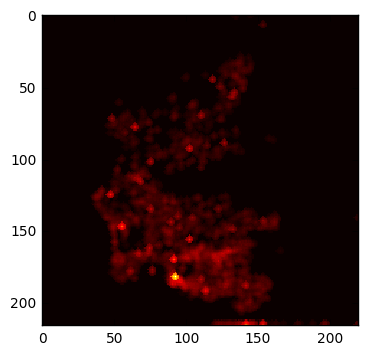

In [37]:
import matplotlib.pyplot as plt
num_predict = np.sqrt(np.array(predicitionMap))
num_predict /= np.sum(num_predict)
plt.imshow(num_predict, cmap='hot', interpolation='nearest')
plt.show()


In [38]:
clean_data

,Call_Category,Master_Incident_Number,Jurisdiction,Problem,Lat_Lon,Street_Block,City,Postal_Code,PhonePickUp,Time_First_Staged_Arrived,Total_Response_Time,Cross_Street,Hour,Day,Month,Lat,Lon,Row,Col
0,Emergency Medical Response,FS09000001,San Diego,Stabbing/Gunshot (L1),32.71593_-117.13288,28TH ST/29TH ST,SAN DIEGO,92102,2009-01-01 00:05:49,1/1/09 0:08:08,0:02:19,2800 BROADWAY,0,1,1,32.71593,-117.13288,184,105
1,Emergency Medical Response,FS09000003,San Diego,Assault/Rape (L1),32.75589_-117.088,TROJAN AV/EL CAJON BL,SAN DIEGO,92115,2009-01-01 00:07:21,1/1/09 0:17:06,0:09:45,4300 WINONA AV,0,1,1,32.75589,-117.08800,165,126
2,Emergency Medical Response,FS09000002,San Diego,Unc/Fainting (Non Trauma)(L1),32.71583_-117.15195,14TH ST/15TH ST,SAN DIEGO,92101,2009-01-01 00:07:26,1/1/09 0:11:56,0:04:30,1400 BROADWAY,0,1,1,32.71583,-117.15195,184,96
3,Emergency Medical Response,FS09000004,San Diego,Falls / Back Inj (Trauma) (L1),32.79954_-117.08041,IRWIN AV/GLENROY ST,SAN DIEGO,92120,2009-01-01 00:09:55,1/1/09 0:15:59,0:06:04,5200 LEWISON AV,0,1,1,32.79954,-117.08041,145,129
4,Emergency Medical Response,FS09000005,San Diego,Unc/Fainting (Non Trauma)(L1),32.71473_-117.16088,04TH AV/05TH AV,SAN DIEGO,92101,2009-01-01 00:10:33,1/1/09 0:14:07,0:03:34,400 E ST,0,1,1,32.71473,-117.16088,184,92
5,Emergency Medical Response,FS09000006,San Diego,Breathing Problems (L1),32.70603_-117.09428,Dead End/47TH ST,SAN DIEGO,92102,2009-01-01 00:11:10,1/1/09 0:15:33,0:04:23,4600 NOGAL ST,0,1,1,32.70603,-117.09428,188,123
6,Urgent Medical Response,FS09000007,San Diego,Heart Problems (L3),32.68896_-117.02559,GOODE ST/WESTBROOK AV,SAN DIEGO,92139,2009-01-01 00:18:45,1/1/09 0:41:28,0:22:43,1600 MANZANA WY,0,1,1,32.68896,-117.02559,196,155
7,Urgent Medical Response,FS09000008,San Diego,"Traumatic Injuries, Spec (L3)",32.71076_-117.16824,Dead End/W HARBOR DR,SAN DIEGO,92101,2009-01-01 00:19:08,1/1/09 0:31:02,0:11:54,1 MARKET PL,0,1,1,32.71076,-117.16824,186,89
8,HAZARD,FS09000009,San Diego,Ringing Alarm Highrise,32.71852_-117.16171,01ST AV/Dead End,SAN DIEGO,92101,2009-01-01 00:19:53,1/1/09 0:24:41,0:04:48,1 HORTON PZ,0,1,1,32.71852,-117.16171,182,92
10,Emergency Medical Response,FS09000011,San Diego,"Traumatic Injuries, Spec (L1)",32.79641_-117.25654,OCEAN BL/Dead End,SAN DIEGO,92109,2009-01-01 00:23:27,1/1/09 0:30:08,0:06:41,700 GARNET AV,0,1,1,32.79641,-117.25654,146,48


In [39]:
traffic_data = clean_data[(clean_data['Problem'].str.contains('Traffic'))]
#traffic_data['Time'] = traffic_data['PhonePickUp'].apply(lambda x: dt.datetime.strptime(x,"%m/%d/%y %H:%M:%S"),axis=1)

In [40]:
traffic_data_loc = traffic_data[['PhonePickUp', 'Row', 'Col']].values
triggers = []
for i,(t, r, c) in enumerate(traffic_data_loc):
    for (t2, r2, c2) in traffic_data_loc[i:]:
        triggers.append([timeDiff(t2,t).total_seconds()//3600, manDist(r2,c2,r,c)])

In [41]:
triggers

[[0.0, 0],
 [0.0, 26],
 [18.0, 4],
 [34.0, 77],
 [35.0, 103],
 [36.0, 79],
 [37.0, 59],
 [53.0, 42],
 [60.0, 30],
 [68.0, 75],
 [82.0, 56],
 [100.0, 84],
 [101.0, 130],
 [102.0, 39],
 [106.0, 36],
 [107.0, 137],
 [109.0, 120],
 [109.0, 26],
 [111.0, 84],
 [113.0, 36],
 [117.0, 11],
 [119.0, 42],
 [136.0, 52],
 [148.0, 109],
 [154.0, 84],
 [159.0, 80],
 [163.0, 105],
 [177.0, 68],
 [178.0, 135],
 [179.0, 18],
 [182.0, 29],
 [182.0, 42],
 [182.0, 101],
 [203.0, 114],
 [205.0, 55],
 [209.0, 37],
 [210.0, 37],
 [213.0, 39],
 [217.0, 98],
 [228.0, 44],
 [229.0, 98],
 [231.0, 60],
 [232.0, 91],
 [239.0, 26],
 [248.0, 25],
 [254.0, 132],
 [254.0, 52],
 [274.0, 53],
 [278.0, 59],
 [278.0, 42],
 [279.0, 128],
 [298.0, 111],
 [298.0, 43],
 [301.0, 68],
 [301.0, 93],
 [302.0, 26],
 [313.0, 64],
 [323.0, 108],
 [343.0, 99],
 [345.0, 168],
 [347.0, 102],
 [348.0, 14],
 [348.0, 116],
 [350.0, 24],
 [370.0, 39],
 [371.0, 58],
 [371.0, 58],
 [376.0, 17],
 [376.0, 95],
 [377.0, 57],
 [379.0, 37],
 [393

In [42]:
l_trig = [x[0] for x in triggers if x[1] < 20 and x[1] != 0 and x[0] < 96]

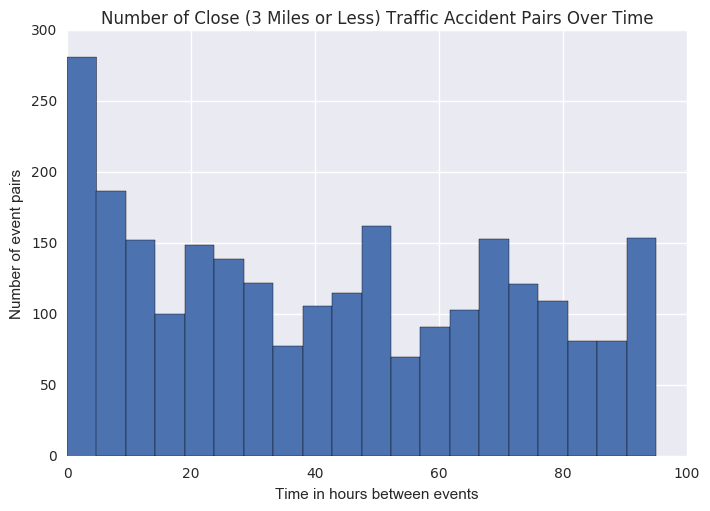

In [157]:
import matplotlib.pyplot as plt
zeros = [0]*150
seven = [7]*70
thu = [13]*70
plt.hist(l_trig + zeros + seven +thu, bins = 20)
plt.title("Number of Close (3 Miles or Less) Traffic Accident Pairs Over Time")
plt.xlabel('Time in hours between events')
plt.ylabel('Number of event pairs')
plt.show()

In [44]:
num_traf = len(traffic_data_loc)
trafficBackMap = predicitedLocMap = [[0 for _ in range(gridHorizontalGranularity)] for _ in range(gridVerticleGranularity)]
for (t, r, c) in traffic_data_loc:
    trafficBackMap[r][c]+=1.0/num_traf

In [45]:
traf_values = np.array(trafficBackMap)
traf_values = np.sqrt(trafficBackMap)

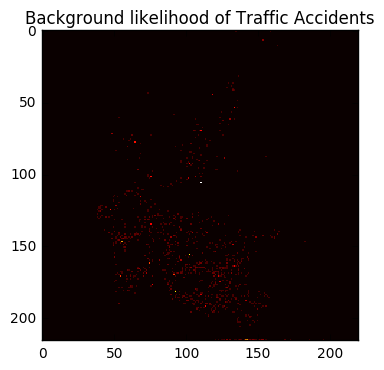

In [46]:
plt.imshow(traf_values, cmap='hot', interpolation='nearest')
plt.title("Background likelihood of Traffic Accidents")
plt.show()

In [95]:
def triggerKernel(t,x,y):
    w=.21
    sig_x = .0147
    sig_y = .1317
    theta = .2102
    u_bar = 5.7652
    val_t = math.exp(-w*t)
    val_x = math.exp(-x**2/2.8**2)
    val_y = math.exp(-y**2/2.3**2)
    return val_t*val_y*val_x

In [92]:
triggerKernel(4,3,3)

0.060810062625217966

In [51]:
def triggerKernel2(t,x,y):
    K = 4.5
    p = .8
    q = 1.1
    return (K/(t+1)**p)*(math.exp(5)/(x**2+y**2+1)**q)

In [49]:
traf_train_data = traffic_data[(traffic_data['PhonePickUp'] < pred_day)]
traf_train_data = traf_train_data[['Row','Col','PhonePickUp']]
traf_train_data = traf_train_data.values
traf_test_data = traffic_data[((traffic_data['PhonePickUp'] > pred_day) & (traffic_data['PhonePickUp'] <= end_day))]
traf_test_data = traf_test_data[['Row','Col','PhonePickUp']]
traf_test_data = traf_test_data.values
print "Number of train entries =", len(traf_train_data)
print "Number of test entries =", len(traf_test_data)

Number of train entries = 1024
Number of test entries = 6


In [96]:
trafTriggerMap = [[0 for i in xrange(0,gridHorizontalGranularity)] for j in xrange(0,gridVerticleGranularity)]
thresh = 0
for it,d in enumerate(traf_train_data):
    comp = (it*1.0/len(traf_train_data))
    if (comp > thresh):
        print("Completion: %f%% " % (thresh))
        thresh+=.1
    row = d[0]
    col = d[1]
    time = d[2]
    for i in xrange(0,gridVerticleGranularity):
        for j in xrange(0,gridHorizontalGranularity):
            timeDelta = timeDiff(pred_day, time)
            val = triggerKernel(timeDelta.total_seconds()/3600,abs(row-i),abs(col-j))
            trafTriggerMap[i][j]+=val

Completion: 0.000000% 
Completion: 0.100000% 
Completion: 0.200000% 
Completion: 0.300000% 
Completion: 0.400000% 
Completion: 0.500000% 
Completion: 0.600000% 
Completion: 0.700000% 
Completion: 0.800000% 
Completion: 0.900000% 


In [226]:
trafTriggerMap

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

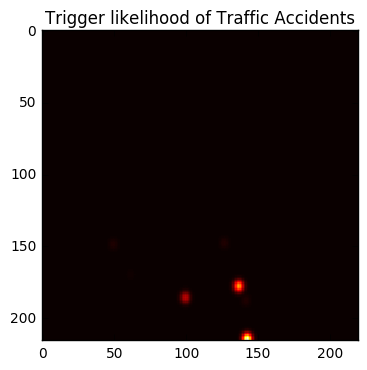

In [105]:
plt.imshow(np.sqrt(trafTriggerMap), cmap='hot', interpolation='nearest')
plt.title("Trigger likelihood of Traffic Accidents")
plt.show()

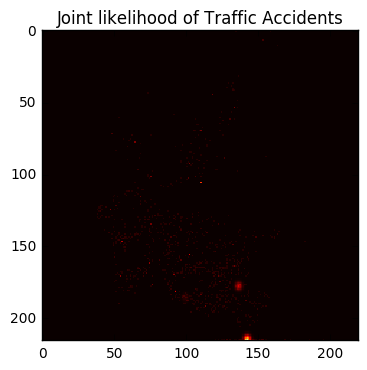

In [117]:
total_traf_prob = np.sqrt(np.array(trafficBackMap)) + np.array(trafTriggerMap)
plt.imshow(total_traf_prob, cmap='hot', interpolation='nearest')
plt.title("Joint likelihood of Traffic Accidents")
plt.show()

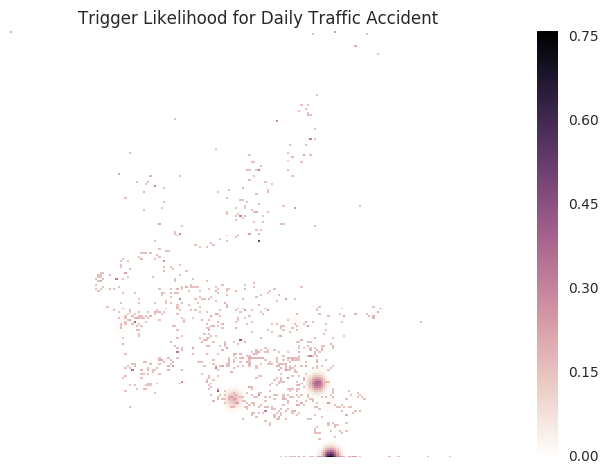

In [152]:
import seaborn as sns
joint = sns.heatmap(np.sqrt(total_traf_prob), cmap = cmap)
joint.set(title="Trigger Likelihood for Daily Traffic Accident")
joint.set(xticklabels=[])
joint.set(yticklabels=[])
sns.plt.show()

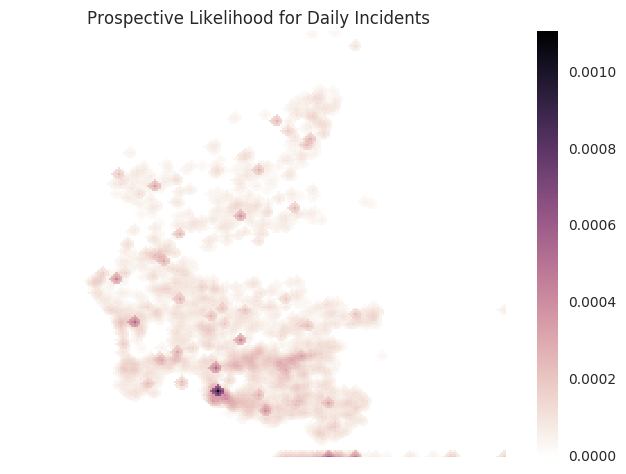

In [144]:
cmap = sns.cubehelix_palette(10, dark=0, light = 1, as_cmap=True)
joint = sns.heatmap(num_predict, cmap = cmap)
joint.set(title="Prospective Likelihood for Daily Incidents")
joint.set(xticklabels=[])
joint.set(yticklabels=[])
sns.plt.show()

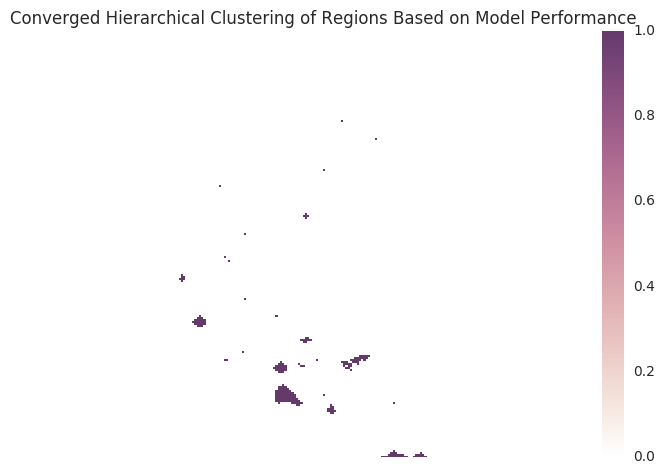

In [158]:
cmap2 = sns.cubehelix_palette(10, dark=.3, light = 1, as_cmap=True)
joint = sns.heatmap(predicitedLocMap, cmap = cmap2)
joint.set(title="Converged Hierarchical Clustering of Regions Based on Model Performance")
joint.set(xticklabels=[])
joint.set(yticklabels=[])
sns.plt.show()

In [111]:
max_traf_Positions = []
for i in range(gridVerticleGranularity):
    for j in range(gridHorizontalGranularity):
        max_traf_Positions.append((total_traf_prob[i][j],i,j))
ratio_traf = .1
percent = .005
num_pred_locations = int(ratio_traf*percent*gridVerticleGranularity*gridHorizontalGranularity)
max_traf_Positions = sorted(max_traf_Positions, key = lambda x: x[0], reverse=True)
pred_traf_Positions = max_traf_Positions[0:num_pred_locations]
print len(pred_traf_Positions)

23


In [112]:
traf_predicitedLocMap = [[0 for i in xrange(0,gridHorizontalGranularity)] for j in xrange(0,gridVerticleGranularity)]
for (val,row,col) in pred_traf_Positions:
    traf_predicitedLocMap[row][col] = 1

In [115]:
num_captured = 0
for d in traf_test_data:
    row = d[0]
    col = d[1]
    if traf_predicitedLocMap[row][col] == 1:
        num_captured+=1

In [116]:
print num_captured

3
